# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Имопртируем необходимые библиотеки и классы

In [16]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.dummy import DummyClassifier

# Импортирую библиотеку для отображения статус-бара
import tqdm

### Общая информация по датасету

In [17]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Датасет содержит 10К строк. Все поля кроме 'Tenure' не содержат пустые значения (пропуски).

Названия полей приведу к "питоновскому стилю" - добавление нижних подчеркиваний, запись в нижнем регистре

Изменим названия полей и посмотрим первые 5 строк.


In [18]:
# вставим подчеркивания
data.rename(columns={'RowNumber':'row_number','CustomerId':'customer_id','CreditScore':'credit_score',
                    'NumOfProducts':'num_of_products','HasCrCard':'has_cr_card',
                    'IsActiveMember':'is_active_member','EstimatedSalary':'estimated_salary'
                   }, inplace = True)
# переведем в нижний регистр
data.columns = data.columns.str.lower()
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим дубликаты

In [19]:
data.duplicated().sum()

0

Поля row_number, customer_id, surname - очевидно, не имеют ценности в рамках нашей задачи. Удалим их.

In [20]:
data = data.drop(['row_number','customer_id','surname'], axis=1)

Посмотрим распределение значений числовых полей

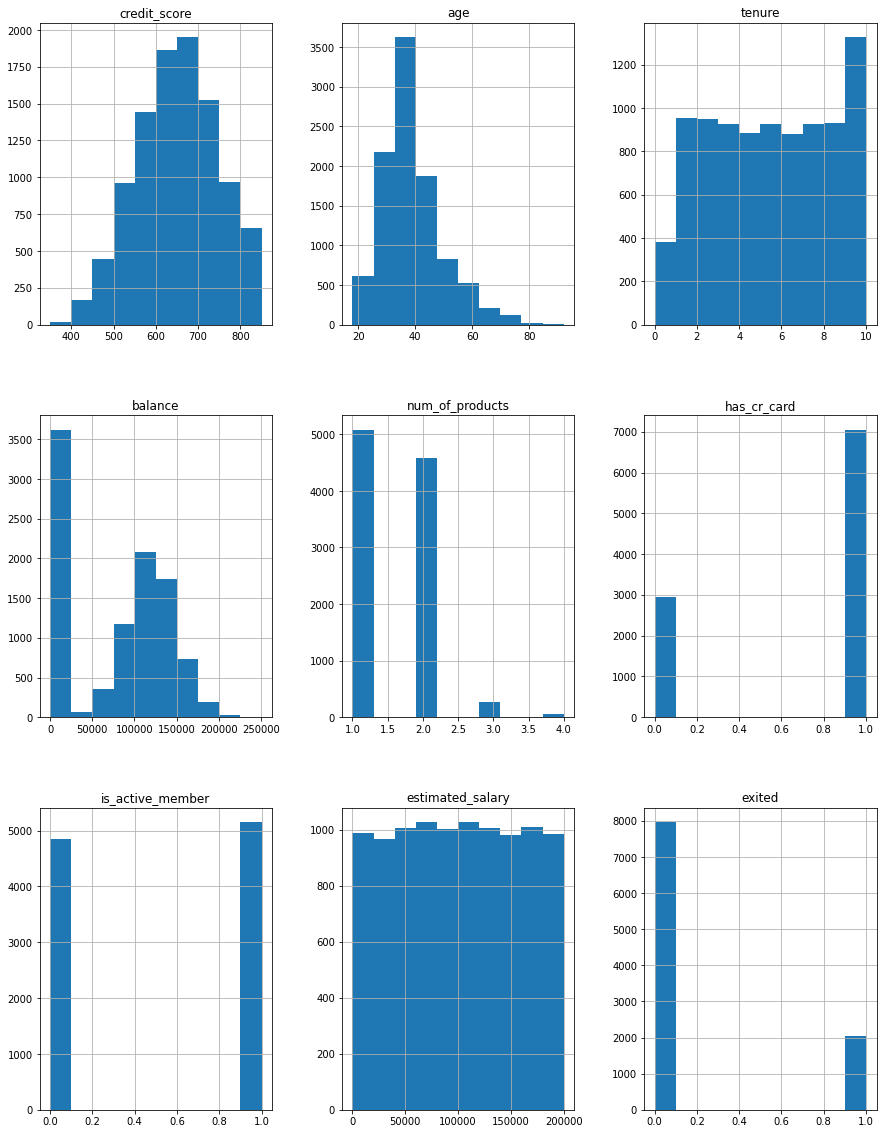

In [21]:
data.hist(figsize=(15, 20));

Из примечательного видим, что клиентский "стаж" распределен равномерно с заметным пиком в "старых" клиентах (стаж - 10 лет). Также видим пик количества клиентов с низкими значениями баланса.

Посмотрим сводную стат информацию

In [22]:
def summary_table():
    df = pd.DataFrame({'col_null_count':data.isna().sum()},index=data.isna().sum().index)
    df['col_type']=data.dtypes
    df = df.join(data.describe().transpose())
    df['mean_median']=(df['mean']-df['50%'])/df['50%'] # превышение среднего над медианой
    df_style = {'count':'{:.0f}','mean':'{:.2f}','mean_median':'{:.2%}', # словарь для форматирования вывода
                'std':'{:.2f}','min':'{:.1f}','25%':'{:.1f}','50%':'{:.1f}','75%':'{:.1f}','max':'{:.1f}'}
    return df, df_style
df, df_style = summary_table()
df.style.format(df_style)

,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
credit_score,0,int64,10000,650.53,96.65,350.0,584.0,652.0,718.0,850.0,-0.23%
geography,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
gender,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
age,0,int64,10000,38.92,10.49,18.0,32.0,37.0,44.0,92.0,5.19%
tenure,909,float64,9091,5.00,2.89,0.0,2.0,5.0,7.0,10.0,-0.05%
balance,0,float64,10000,76485.89,62397.41,0.0,0.0,97198.5,127644.2,250898.1,-21.31%
num_of_products,0,int64,10000,1.53,0.58,1.0,1.0,1.0,2.0,4.0,53.02%
has_cr_card,0,int64,10000,0.71,0.46,0.0,0.0,1.0,1.0,1.0,-29.45%
is_active_member,0,int64,10000,0.52,0.50,0.0,0.0,1.0,1.0,1.0,-48.49%
estimated_salary,0,float64,10000,100090.24,57510.49,11.6,51002.1,100193.9,149388.2,199992.5,-0.10%


Отметим заметное расхождение медианы и среднего в поле balance- это связано с большой долей нулей

### Обработка пропусков

Отдельно посмотрим как распределены значения полей на пропусках в поле tenure. Т.е. попробуем определить закономерности появления пропусков от значений в других полях (например, вдруг почти все пропуски соответствуют интервалу значений баланса от 25000-26000, или каким то подобным образом сконцентрированы в интервалах значений других полей?)

Использую для этого написанную мной для прошлых проектов функцию.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>В итоге ОКАЗАЛОСЬ, что достаточно было посмотреть распределение НЕПУСТЫХ значений. Но в данный момент мы не можем ничего определенного сказать о ПРОПУЩЕННЫХ значениях - их распределение мы не знаем. С помощью данной функции я исследую именно пропуски: есть ли заметная концентрация пропусков на каких то определенных (узких) интервалах значений в других полях. Если есть, то можно уже смотреть в обратную сторону: как распределены непустые значения tenure на этих найденых узких интервалах значений других полей. Теоретически, таким образом мы можем более осмысленно заполнять пропуски. Но как видим - не в этом случае.
    
Понятно, что проект и задача не об этом, но тем не менее, считаю такую проверку пропусков, которые составляют 10% датасета, необходимой перед их заполнением 
   </font>
</div>

In [23]:
# II. Функция построения датафрейма распределния значений расчетных полей по интервалам
#             при фильтрации по заданному условию в базовом поле
#             в качестве базовых полей можно использовать:
#             1. в случае анализа пропусков (.isna()) - любые поля таблицы
#             2. при использовании условий фильтрации - только числовые поля

# блок значений переменных функции / описание ниже,  в теле функции
#-------------------------------------------------------------
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = False   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк

    # зависимость переменных:
# top <= panni
# somple = False -> condition != ''
# b_list_use = True -> b_list != ['']
# c_list_use = True -> c_list !=['']

#--------------------------------------------------------------

def condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,
                     cond_count_use):
    
    # panni -     количество корзин для числовых полей
    # qmx -       верхний квантиль для ограничения интервалов (для отсечения верхних выбросов)
    # qmn -       нижний квантиль для ограничения интервалов (для отсечения нижних выбросов)
    # condition - условиe, по которому фильтруется базовое поле
               #  например condition = '@cond_clmn.isna()' или '@cond_clmn > @cond_clmn.quantile(0.9)'
               #  где @cond_clmn - базовое поле (например из списка b_list)
    # simple -    если = True - просто смотрим распределения по всем полям по их корзинам
               #  без использования условия в базовом поле
    # data -      общий анализируемый датафрейм
    # df -        сводный для data датафрейм (названия, типы полей, статметрики)
    # b_list -    список базовых полей для проверки на условия
              #   для проверки пропусков возможны любые поля, для других условий- пока только числовые
    # b_list_use- True - использовать заданный список, False- используется все поля таблицы
    # c_list -    список расчетных полей
    # c_list_use- True - использовать заданный список, False- используется все поля таблицы
    # cond_count_use - True - считать долю корзины как отношение корзины к количеству строк,
              #   которые были отобраны в фильтре по базовому полю
              #   False - отношение к общему количеству строк расчетного поля

    df, df_style = summary_table()
  
    digit_list = df[(df['col_type'] == 'int64') |
                    (df['col_type'] == 'float64') ].index     # список числовых полей для расчетных полей

    date_list  = df[(df['col_type'] == 'datetime64[ns]')].index  # список числовых полей с датами
    
    other_list = df[(df['col_type'] != 'int64') &
                    (df['col_type'] != 'float64') &
                    (df['col_type'] != 'datetime64[ns]') &
                    (df.index != 'first_day_exposition')
                # & (df.index != 'first_day_exposition_date')
                                                        ].index # список нечисловых полей для расчетных полей
                                                                # функция получилась не совсем универсальной
                                                                # из-за поля first_day_exposition
    if simple: # если простой анализ (без фильтрации в базовом поле)
        null_list = ['simple'] # имя переменной null_list было взято изначально, когда предполагалось
                               # использовать функцию только для анализа пустых значений
                               # это список базовых полей, по которым фильтруется таблица
    elif condition == '@cond_clmn.isna()':
        null_list = df[(df['col_null_count'] != 0)].index    # список полей с пропусками для базовых полей
    else:
        null_list = digit_list # список числовых полей: если не смотрим .isna() и не simple
                               # значит условие содержит операции сравнения, т.е. работу с числами
                               # условия для строковых данных пока не используются в функции
    if b_list_use and b_list != [''] and simple: # фильтрация списка расчетных полей
        digit_list= digit_list[digit_list.isin(b_list)]
        other_list= other_list[other_list.isin(b_list)]
        date_list = date_list[date_list.isin(b_list)]
    if b_list_use and b_list != ['']: # фильтрация списка базовых полей
        null_list = b_list

    if c_list_use and not simple: # фильтрация списка расчетных полей
        digit_list = digit_list[digit_list.isin(c_list)]
        other_list = other_list[other_list.isin(c_list)]
        date_list  = date_list[date_list.isin(c_list)]
    
        
    nd = pd.DataFrame(index=range(panni)) # создадим сводный датафрейм с корзинами разбиений,
                                          # в который будем добавлять столбцы
    
   # 1. проходим по списку базовых полей (с пропусками)
    for base in null_list:                # 
        if simple:
            idx_true=df.index[0]+' == '+df.index[0] # условие для полного отбора
            cond = idx_true               # если выбрано условие simple=True - не проходим по базовым полям,
                                          # не фильтруем по условию .isna() в базовом поле
                                          # просто смотрим всю таблицу на разбиения
        else:
            cond_clmn = data[base]
            cond = condition              # строка-условие для фильтрации датафрейма по базовому полю
        
        # 1.1. вложенный цикл по расчетным числовым полям
        for calc in digit_list:           # 
            #print('calc',calc)
            panniers = panni              # на каждой итерации цикла обновляем количество корзин
            col_uniq = data.query(cond)[calc].nunique()  # количество уникальных значений в расчетном поле 
            panniers = min(panniers,col_uniq) # количество корзин должно быть не больше кол-ва уник значений
            panniers = max(panniers,1)    # количество корзин должно быть больше 0
            if col_uniq <= panni:         # для малого количества уникальных значений "режем"
                bins = np.linspace((data.query(cond)[calc].min()-1), # отнимаем 1 для включения нижней границы
                                   data.query(cond)[calc].max(), col_uniq+1)  # интервалы по уникальным значенияч
                #bins = col_uniq
                cut_label = range(col_uniq) # метки (индексы) корзин для всех полей сделаем однотиными- т.е. пронумеруем
            else:                         # для больших рядов "режем" на ровные части с отсечением
                bins=np.linspace((data.query(cond)[calc].quantile(qmn)-1), # нижнего квантиля
                                  data.query(cond)[calc].quantile(qmx),    # и верхнего квантиля
                                  panniers+1)
                cut_label = range(min(panniers,bins.shape[0]))
            if col_uniq>0: #and base != calc
                nulldata  = pd.cut(data.query(cond)[calc], # разбивка по интервалам, индекс- нумерация (0-panniers)
                                   bins,
                                   labels=cut_label).value_counts(sort=False)
                nulldata1 = pd.cut(data.query(cond)[calc], # разбивка по интервалам - индекс- границы интервалов
                                   bins).value_counts(sort=False)
                col_int = calc+'_int'  # наименование поля интервала- расчетное поле + суфикс
                col_cnt = calc+'_cnt'  # наименование поля количество значений в интервале- расчетное поле + суфикс
                cond_count = data[~data[calc].isna()][calc].count() # кол-во непустых значений в расчетном поле
                #print('calc:',calc,', cond_count: ',cond_count,', data[calc].count(): ',data[calc].count())
                if cond_count_use:     # кол-во непустых значений в расч поле, в строках отфильтрованных по условию
                    cond_count = data.query(cond)[calc].count()
                if cond_count > 0:     # исключим деление на ноль
                    nd_col = pd.DataFrame({(base,col_int):nulldata1.index,
                                           (base,col_cnt):nulldata
                                           /cond_count},
                                            index=range(panniers))
                else:
                    nd_col = pd.DataFrame({(base,col_int):nulldata1.index,
                                           (base,col_cnt):0},
                                            index=range(panniers))
                nd = pd.concat((nd,nd_col),axis=1) # добавление полученных значений разбивки в сводный датафрейм
        
        
        # 1.2. вложенный цикл для нечисловых полей
        for calc in other_list:
            col_uniq = data.query(cond)[calc].nunique()  # количество уникальных значений в расчетном поле 
            panniers = max(col_uniq,1)
            panniers = min(panni,col_uniq)
            nulldata  = data.query(cond)[calc].value_counts(sort=False).nlargest(panniers) # берем только то, что "влазит"
                                                                                           # в нашу разбивку
            col_int = calc+'_int'
            col_cnt = calc+'_cnt'
            nd_col  = pd.DataFrame({(base,col_int):nulldata.index},index=range(panniers))
            nulldata.reset_index(drop=True,inplace=True)
            cond_count = data[~data[calc].isna()][calc].count() # кол-во непустых значений в расчетном поле
            if cond_count_use:     # кол-во непустых значений в расч поле, в строках отфильтрованных по условию
                cond_count = data.query(cond)[calc].count()
            if cond_count > 0:
                nd_col2 = pd.DataFrame({(base,col_cnt):nulldata
                                       /cond_count},
                                        index=range(panniers))
            else:
                nd_col2 = pd.DataFrame({(base,col_cnt):0},
                                        index=range(panniers))
            #nd_col = pd.concat((nd_col,nd_col2),axis=1)
            nd = pd.concat((nd,nd_col,nd_col2),axis=1)
        
        for calc in date_list:
            calc_clmn = data[calc]
            col_int = calc+'_int'
            col_cnt = calc+'_cnt'
            if cond != '' and cond != '@cond_clmn.isna()': # фильтрация расчетного поля для построения интервалов
                cond = cond+' and @calc_clmn > @calc_clmn.quantile(@qmn) and @calc_clmn < @calc_clmn.quantile(@qmx)'
            else:
                cond = '@calc_clmn > @calc_clmn.quantile(@qmn) and @calc_clmn < @calc_clmn.quantile(@qmx)'
            col_uniq = data.query(cond)[calc].nunique()  # количество уникальных значений в расчетном поле 
            panniers = max(col_uniq,1)
            panniers = min(panni,col_uniq)
            nulldata  = pd.cut(data.query(cond)[calc], # разбивка по интервалам, индекс- нумерация (0-panniers)
                                   bins=panniers).value_counts(sort=False)
            nd_col  = pd.DataFrame({(base,col_int):nulldata.index},index=range(panniers))
            nulldata.reset_index(drop=True,inplace=True)
            cond_count = data[~data[calc].isna()][calc].count() # кол-во непустых значений в расчетном поле
            if cond_count_use:     # кол-во непустых значений в расч поле, в строках отфильтрованных по условию
                cond_count = data.query(cond)[calc].count()
            if cond_count > 0:
                nd_col2 = pd.DataFrame({(base,col_cnt):nulldata
                                       /cond_count},
                                        index=range(panniers))
            else:
                nd_col2 = pd.DataFrame({(base,col_cnt):0},
                                        index=range(panniers))
            nd = pd.concat((nd,nd_col,nd_col2),axis=1)
            
    return nd
#fract_table = condition_depend(panni,qmx,qmn,condition,simple,
#                     data,
#                     b_list,b_list_use,
#                     c_list,c_list_use,cond_count_use)
#fract_table

Создам отдельные списки имен полей

In [24]:
cat_obj_list = ['geography','gender']
cat_int_list = ['num_of_products','has_cr_card','is_active_member']
no_cat_list = ['credit_score','age','tenure','balance','estimated_salary']
targ_list = ['exited']

Посмотрим пропуски tenure для категорийных текстовых полей

In [25]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['tenure']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list =  cat_obj_list          # список расчетных полей
c_list_use = True      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
fract_table

,"(tenure, geography_int)","(tenure, geography_cnt)","(tenure, gender_int)","(tenure, gender_cnt)"
0,France,0.510451,Male,0.531353
1,Spain,0.251925,Female,0.468647
2,Germany,0.237624,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


Видим, что пропуски не сосредоточены на каком то из категорийных строковых значений

Посмотрим пропуски tenure для категорийных численных полей

In [26]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['tenure']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list =  cat_int_list+targ_list          # список расчетных полей
c_list_use = True      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
fract_table

,"(tenure, num_of_products_int)","(tenure, num_of_products_cnt)","(tenure, has_cr_card_int)","(tenure, has_cr_card_cnt)","(tenure, is_active_member_int)","(tenure, is_active_member_cnt)","(tenure, exited_int)","(tenure, exited_cnt)"
0,"(0.0, 1.0]",0.513751,"(-1.0, 0.0]",0.289329,"(-1.0, 0.0]",0.489549,"(-1.0, 0.0]",0.79868
1,"(1.0, 2.0]",0.446645,"(0.0, 1.0]",0.710671,"(0.0, 1.0]",0.510451,"(0.0, 1.0]",0.20132
2,"(2.0, 3.0]",0.035204,NaN,NaN,NaN,NaN,NaN,NaN
3,"(3.0, 4.0]",0.004400,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что пропуски не сосредоточены на каком то из категорийных численных значений

Посмотрим пропуски tenure для некатегорийных численных полей

In [27]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['tenure']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list =  no_cat_list          # список расчетных полей
c_list_use = True      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
fract_table

,"(tenure, credit_score_int)","(tenure, credit_score_cnt)","(tenure, age_int)","(tenure, age_cnt)","(tenure, balance_int)","(tenure, balance_cnt)","(tenure, estimated_salary_int)","(tenure, estimated_salary_cnt)"
0,"(358.0, 407.2]",0.002200,"(17.0, 24.5]",0.031903,"(-1.0, 20665.475]",0.368537,"(105.67, 20034.148]",0.084708
1,"(407.2, 456.4]",0.022002,"(24.5, 32.0]",0.247525,"(20665.475, 41331.95]",0.005501,"(20034.148, 39962.626]",0.100110
2,"(456.4, 505.6]",0.056106,"(32.0, 39.5]",0.334433,"(41331.95, 61998.425]",0.014301,"(39962.626, 59891.104]",0.121012
3,"(505.6, 554.8]",0.105611,"(39.5, 47.0]",0.226623,"(61998.425, 82664.9]",0.041804,"(59891.104, 79819.582]",0.102310
4,"(554.8, 604.0]",0.148515,"(47.0, 54.5]",0.082508,"(82664.9, 103331.375]",0.124312,"(79819.582, 99748.06]",0.092409
5,"(604.0, 653.2]",0.199120,"(54.5, 62.0]",0.051705,"(103331.375, 123997.85]",0.152915,"(99748.06, 119676.538]",0.110011
6,"(653.2, 702.4]",0.156216,"(62.0, 69.5]",0.014301,"(123997.85, 144664.325]",0.167217,"(119676.538, 139605.016]",0.100110
7,"(702.4, 751.6]",0.149615,"(69.5, 77.0]",0.008801,"(144664.325, 165330.8]",0.075908,"(139605.016, 159533.494]",0.102310
8,"(751.6, 800.8]",0.085809,"(77.0, 84.5]",0.001100,"(165330.8, 185997.275]",0.036304,"(159533.494, 179461.972]",0.092409
9,"(800.8, 850.0]",0.074807,"(84.5, 92.0]",0.001100,"(185997.275, 206663.75]",0.013201,"(179461.972, 199390.45]",0.094609


Для некатегорийных полей, также нельзя выявить какие то характерные диапазоны, которые соответствовали бы значительной концентрации пропусков в поле tenure. можно сделать вывод, что пропуски в клиентском стаже распределены в датасете равномерно. Посмотрим дополнительно зависимость непустых значений полей признаков.

Посмотрим матрицу корреляции полей признаков

In [28]:
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


В целом по полям признаков выраженной взаимной зависимости (мультиколинеарности) не обнаружено.

Поле tenure не имеет выраженной зависимости от других полей.

Т.о. можно сделать вывод, что заполнить какую то часть пропусков поля tenure данными  (значениями из узкого диапазона) на основе каких то взаимосвязей в датасете нельзя.

Т.о. можно заполнить пропуски медианным значением, но поскольку доля таких сэмплов составляет почти 10%, мы очевидно исказим существующее распределение. Поэтому заполним пропуски в соответствии с фактическим распределением непустых значений в поле.

In [29]:
tenure_values = data[data['tenure'].notna()]['tenure'].sort_values().unique()
display(tenure_values)
tenure_proba = data[data['tenure'].notna()]['tenure'].value_counts(normalize=True).sort_index().values
tenure_proba

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

array([0.04201958, 0.10471895, 0.10449896, 0.10207898, 0.09734903,
       0.10196898, 0.09690903, 0.10174898, 0.10262897, 0.09701903,
       0.04905951])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

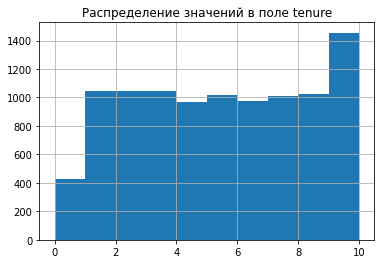

In [31]:
tenure_arr = np.random.choice(tenure_values, len(data), p=tenure_proba)
tenure_df = pd.DataFrame({'ten_prob': tenure_arr},index = data.index)
idx = data[data['tenure'].isna()].index
data.loc[idx,'tenure'] = tenure_df.loc[idx,'ten_prob']
display(data.info())
data['tenure'].hist().set_title('Распределение значений в поле tenure');

Пропуски заполнили. Распределние сохранили.

### Закодируем категориальные строковые признаки

В общем, конечно необходимо кодировать признаки после разбиения датасета на тестовую и обучающую выборки для избежания утечки и предотвращения некорректной работы модели при появлении новых классов в тесте. Но в рамках данного проекта считаю это излишним, т.к. категориальные признаки широко представлены в нашем датасете и очевидно, что попадут во все выборки практически при любом сплите.

Поэтому воспользуемся функцией get_dummies

In [32]:
data = pd.get_dummies(data, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>Здесь решил применить гет_даммис.
        Основная ошибка при использовании гет_даммис может возникнуть из-за появления новых классов, которых нет в обучающей выборке. Этот момент я описал в комментарии выше: "Но в рамках данного проекта считаю это излишним, т.к. категориальные признаки широко представлены в нашем датасете и очевидно, что попадут во все выборки практически при любом сплите." </font>
</div>

"Непредставленной" (drop_first) страной стала Франция, гендером - Female

Поле tenure фактически содержит органиченное количество значений и похоже на категорию, но применять к нему кодирование неправильно, поскольку значения в поле сравнимы между собой и теоретически именно как значения (числа) tenure сами по себе должны влиять на целевое значение.

### Разделение выборки и масштабирование признаков

Далее необходимо масштабировать данные признаков. Предварительно определимся с типами масштабирования для разных полей. Исходя из формы распределния данных (гистограммы выше) применю для полей:
- credit_score, age - стандартизацию,
- tenure, estimated_salary, num_of_products - минимакс,
- has_cr_card, is_active_member - не масштабирую
- balance - поле имеет значительное количество значений около (равные) нуля. Поле отмасштабирую с помощью StandardScaler. В дальнейшем при необходимости посмотрю вариант преобразования поля в категориальное (нулевой баланс / Не нулевой).

Посмотрим значения balance меньше 1000

In [33]:
data[data['balance']<1000]['balance'].unique()

array([0.])

In [34]:
# посмотрим долю нулей
data['balance'].where(data['balance']==0,other=1).value_counts()

1.0    6383
0.0    3617
Name: balance, dtype: int64

Приступим к масштабированию значений признаков.
Чтобы не было утечки, предварительно разделим выборку.

Выборку разделю на train, valid, test

Поиск гиперпараметров буду производить с помощью классов Randomized(Grid)SearchCV. Это немного быстрее прямого перебора. Плюс хочу проверить данные методы в проекте и получить обратную связь от ревьюера в связи с этим. Валидационная выборка теоретически не нужна при решетчатом поиске. Но как выяснилось, кросвалидация применима при работе на балансированной выборке. Поскольку же мы будем в дальнейшем балансировать выборку, используя увеличение редких экземпляров, то решетчатый поиск приведет к утечке. Поэтому при апсэмпле буду использовать простой перебор параметров.

In [35]:
features = data.drop(['exited'], axis=1)
target = data['exited']
# разделим выборку на обучающую и тестовую
features_train_undiv, features_test, target_train_undiv, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [36]:
# еще раз разделим теперь уже обучающую выборку на обучающую и валидационную

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_undiv, target_train_undiv, test_size=0.25, random_state=12345)
display('Обучающая выборка признаков',features_train.shape)
display('Валидационная выборка  признаков',features_valid.shape)
display('Тестовая выборка  признаков',features_test.shape)

'Обучающая выборка признаков'

(6000, 11)

'Валидационная выборка  признаков'

(2000, 11)

'Тестовая выборка  признаков'

(2000, 11)

Масштабирование данных

In [37]:
# составим списки полей для разных типов масштабирования
stand_list = ['credit_score', 'age','balance']
minmax_list = ['tenure', 'estimated_salary', 'num_of_products']

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Где то прочитал, что желательно сохранять исходную форму распределения данных. Поэтому использовал разные скалеры. Нигде запретов в явном виде на такую манипуляцию я не нашел, т.е. вроде как это законно. Плюс хотел посмотреть, что получится при таком миксе. Как видим позже- данные подходят. Конечно, чтобы говорить о пользе или вреде такого подхода, имеет смысл сравнить результаты в двух вариантах. Но здесь главное- я посмотрел, что таким миксом я не "сломал" систему- все работает. )) </font>
</div>

Масштабируем поля с помощью стандартизации

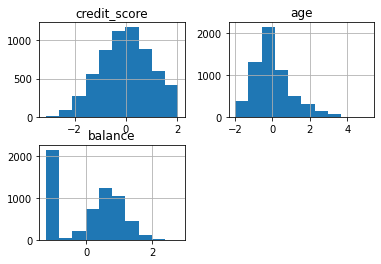

In [38]:
stand_scaler_train = StandardScaler()
stand_scaler_train.fit(features_train[stand_list])
features_train[stand_list]=stand_scaler_train.transform(features_train[stand_list])
features_train[stand_list].hist();

Масштабируем поля с помощью минимакса

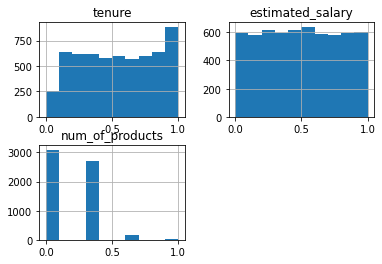

In [39]:
minmax_scaler_train = MinMaxScaler()
minmax_scaler_train.fit(features_train[minmax_list])
features_train[minmax_list] = minmax_scaler_train.transform(features_train[minmax_list])
features_train[minmax_list].hist();

Теперь отмасштабируем валидационную и тестовую выборку полученными скалерами

In [40]:
features_valid[stand_list]=stand_scaler_train.transform(features_valid[stand_list])
features_valid[minmax_list] = minmax_scaler_train.transform(features_valid[minmax_list])

features_test[stand_list]=stand_scaler_train.transform(features_test[stand_list])
features_test[minmax_list] = minmax_scaler_train.transform(features_test[minmax_list])

Подготовка данных проведена. Приступим к исследованию моделей

## Исследование задачи

Исследовать буду 3 модели: логистическую регрессию, деревья решений и случайный лес.
Поиск лучших параметров буду проводить с помощью методов _SearchCV.

Подготовлю функции для решетчатого поиска

### Логистическая регрессия. Поиск ГП.

In [41]:
# функция обучения и вывода метрик
def model_out(model,features_train,target_train,features_valid,target_valid):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    f1 = f1_score(target_valid, predictions_valid)
    roc_auc = roc_auc_score(target_valid,probabilities_one)
    accuracy = accuracy_score(target_valid,predictions_valid)
    recall = recall_score(target_valid,predictions_valid)
    precission = precision_score(target_valid,predictions_valid)
    return model,f1,roc_auc,accuracy,recall,precission

In [42]:
# функция для вывода данных roc_curve для обученной модели
def roc_curve_data(model,target_valid):
    predictions_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    fpr, tpr, threshholds = roc_curve(target_valid,probabilities_one)
    return fpr, tpr, threshholds

In [43]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
C_list = [0.1,1,10,50]
max_iter_list = [int(x) for x in range(100, 2200, 500)]

In [44]:
# функция поиска ГП для лог.регрессии
def logr_search(features_train,target_train,
                features_valid,target_valid,
                class_weight=None):
    f1_best_list_logr = [0,0,0,0,0,0,0] # список значений при лучшем f1
                             # f1_best_list[0] - f1
                             # f1_best_list[1] - roc_auc
                             # f1_best_list[2] - accuracy
                             # f1_best_list[3] - recall
                             # f1_best_list[4] - precission
                             # f1_best_list[5] - гиперпараметр C
                             # f1_best_list[6] - гиперпараметр max_iter
    roc_auc_best_list_logr = [0,0,0,0,0,0,0] # список значений при лучшем roc_auc

    for c_var in tqdm.tqdm(C_list):
        for i_var in max_iter_list:
            model_logr = LogisticRegression(random_state=12345, solver='lbfgs',
                                C=c_var,max_iter=i_var,
                                class_weight=class_weight)
            model,f1,roc_auc,accuracy,recall,precission = model_out(
                                    model_logr,features_train,
                                    target_train,features_valid,target_valid)
            if f1 > f1_best_list_logr[0]:
                f1_best_list_logr = [f1,roc_auc,accuracy,
                                recall,precission,c_var,i_var]
            if roc_auc > roc_auc_best_list_logr[1]:
                roc_auc_best_list_logr = [f1,roc_auc,accuracy,
                                     recall,precission,c_var,i_var]
    return f1_best_list_logr, roc_auc_best_list_logr

Определим лучшие параметры лог.регерессии

In [45]:
f1_best_list_logr, roc_auc_best_list_logr = logr_search(features_train,target_train,
                                              features_valid,target_valid)

100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


Посмотрим лучшие результаты

In [46]:
result = pd.DataFrame(columns=[
    'f1','roc_auc','accuracy','recall','precission','C','max_iter'])

In [47]:
result.loc['logr_f1']=f1_best_list_logr
result.loc['logr_roc_auc'] = roc_auc_best_list_logr
result

,f1,roc_auc,accuracy,recall,precission,C,max_iter
logr_f1,0.301318,0.770045,0.8145,0.204604,0.571429,1.0,100.0
logr_roc_auc,0.293893,0.770408,0.8150,0.196931,0.578947,0.1,100.0


При лучшем roc_auc метрика f1 меньше своего максимума.

Посмотрим метрики f1 и roc_auc посчитав их напрямую- обучим модель с найденными лучшими параметрами

In [48]:
# функция для построения графика ROC CURVE
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

Обучим модель на лучших параметрах и выведем метрики

In [49]:
logr_best = LogisticRegression(random_state=12345, solver='lbfgs',C=1,max_iter=100)

In [50]:
def best_model(model,features_train,target_train,features_valid,target_valid,
               prnt=False):
    model_fited,f1,roc_auc,accuracy,recall,precission = model_out(
                            model,features_train,
                            target_train,features_valid,target_valid)
    if prnt:
        print('метрика f1 ----------',f1.round(5))
        print('метрика roc_auc -----',roc_auc.round(4))
        print('метрика accuracy ----',accuracy.round(4))
        print('метрика recall ------',recall.round(4))
        print('метрика precission --',precission.round(4))
    return model_fited

In [51]:
logr_best_fited = best_model(logr_best,features_train,target_train,
                             features_valid,target_valid,prnt=True)

метрика f1 ---------- 0.30132
метрика roc_auc ----- 0.77
метрика accuracy ---- 0.8145
метрика recall ------ 0.2046
метрика precission -- 0.5714


In [52]:
# сохраним данные для roc_curve
fpr_logr_best, tpr_logr_best, threshholds_logr_best = roc_curve_data(
                                                    logr_best_fited,target_valid)

### Дерево решений. Поиск ГП.

In [53]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
max_depth_list = [int(x) for x in range(10, 30, 2)]
min_samples_split_list = [int(x) for x in range(2,40,2)]
min_samples_leaf_list = [int(x) for x in range(1,20,2)]

In [54]:
#param = pd.DataFrame() # служебный датафрейм - не используется

In [55]:
# функция поиска ГП в дереве решений
def dtcl_search(features_train,target_train,
                features_valid,target_valid,
                class_weight=None):
    f1_best_list_dtcl = [0,0,0,0,0,0,0,0] # список значений при лучшем f1
                             # f1_best_list[0] - f1
                             # f1_best_list[1] - roc_auc
                             # f1_best_list[2] - accuracy
                             # f1_best_list[3] - recall
                             # f1_best_list[4] - precission
                             # f1_best_list[5] - гиперпараметр max_depth
                             # f1_best_list[6] - гиперпараметр min_samples_split
                             # f1_best_list[7] - гиперпараметр min_samples_leaf
    roc_auc_best_list_dtcl = [0,0,0,0,0,0,0,0] # список значений при лучшем roc_auc

#     id = 0
#     roc_auc_best = 0
#     f1_best = 0
    for md in tqdm.tqdm(max_depth_list):
        for spl in min_samples_split_list:
            for leaf in min_samples_leaf_list:
                model_dtcl = DecisionTreeClassifier(
                                        random_state=12345,
                                        max_depth=md,
                                        min_samples_split=spl,
                                        min_samples_leaf=leaf,
                                        class_weight=class_weight)
                model,f1,roc_auc,accuracy,recall,precission = model_out(
                                        model_dtcl,
                                        features_train,target_train,
                                        features_valid,target_valid)
#                 f1_list = f1_best_list_dtcl[0]
#                 ra_list = roc_auc_best_list_dtcl[1]
#                 param.loc[id,['md','spl','leaf','f1','f1_l','roc_auc','ra_l',
#                               'f1_best','roc_auc_best']]= [
#                     md,spl,leaf,f1,f1_list,roc_auc,ra_list,0,0]
                if f1 > f1_best_list_dtcl[0]:
                    f1_best_list_dtcl = [f1,roc_auc,accuracy,
                                         recall,precission,md,spl,leaf]
#                     f1_best += 1
#                     param.loc[id,['f1_best']]=f1_best
                if roc_auc > roc_auc_best_list_dtcl[1]:
                    roc_auc_best_list_dtcl = [f1,roc_auc,accuracy,
                                              recall,precission,md,spl,leaf]
#                     roc_auc_best +=1
#                     param.loc[id,['roc_auc_best']]=roc_auc_best
#                 id +=1
                    
    return f1_best_list_dtcl, roc_auc_best_list_dtcl

Определим лучшие параметры

In [56]:
f1_best_list_dtcl, roc_auc_best_list_dtcl = dtcl_search(
                                features_train,target_train,
                                features_valid,target_valid)

100%|██████████| 10/10 [01:06<00:00,  6.70s/it]


In [57]:
# посмотрим итоговые метрики
result.loc['dtcl_f1',
           ['f1','roc_auc','accuracy','recall','precission',
      'max_depth','min_samples_split','min_samples_leaf']] = f1_best_list_dtcl
result.loc['dtcl_roc_auc',
           ['f1','roc_auc','accuracy','recall','precission',
'max_depth','min_samples_split','min_samples_leaf']]= roc_auc_best_list_dtcl
result.transpose()

,logr_f1,logr_roc_auc,dtcl_f1,dtcl_roc_auc
f1,0.301318,0.293893,0.568047,0.551724
roc_auc,0.770045,0.770408,0.797586,0.814983
accuracy,0.814500,0.815000,0.854000,0.850500
recall,0.204604,0.196931,0.491049,0.470588
precission,0.571429,0.578947,0.673684,0.666667
C,1.000000,0.100000,NaN,NaN
max_iter,100.000000,100.000000,NaN,NaN
max_depth,NaN,NaN,12.000000,10.000000
min_samples_split,NaN,NaN,2.000000,36.000000
min_samples_leaf,NaN,NaN,15.000000,17.000000


При лучшем roc_auc метрика f1 немного меньше своего максимума. Также метрика не дотягивает до требуемого порога 0.59

Обучим модель на лучших параметрах и сохраним данные для roc_curve.

In [58]:
dtcl_best = DecisionTreeClassifier(random_state=12345, max_depth=10,
                                   min_samples_split=30, min_samples_leaf=13)

In [59]:
dtcl_best_fited = best_model(dtcl_best,features_train,target_train,
                             features_valid,target_valid,prnt=False)

In [60]:
# сохраним данные для roc_curve
fpr_dtcl_best, tpr_dtcl_best, threshholds_dtcl_best = roc_curve_data(
                                                    dtcl_best_fited,target_valid)

### Случайный лес. Поиск ГП

In [61]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
n_estimators_list = [int(x) for x in range(30, 100, 10)]
max_depth_list = [int(x) for x in range(10, 30, 4)]
min_samples_split_list = [int(x) for x in range(2,30,4)]
min_samples_leaf_list =  [int(x) for x in range(1,20,4)]

Определим лучшие гиперпараметры

In [62]:
# функция для поиска ГП на случайном лесе
def rfcl_search(features_train,target_train,
                features_valid,target_valid,
                class_weight=None):
    f1_best_list_rfcl = [0,0,0,0,0,0,0,0,0] # список значений при лучшем f1
                             # f1_best_list[0] - f1
                             # f1_best_list[1] - roc_auc
                             # f1_best_list[2] - accuracy
                             # f1_best_list[3] - recall
                             # f1_best_list[4] - precission
                             # f1_best_list[5] - гиперпараметр max_depth
                             # f1_best_list[6] - гиперпараметр min_samples_split
                             # f1_best_list[7] - гиперпараметр min_samples_leaf
                             # f1_best_list[8] - гиперпараметр n_estimators
    roc_auc_best_list_rfcl = [0,0,0,0,0,0,0,0,0] # список значений при лучшем roc_auc
    for est in tqdm.tqdm(n_estimators_list):
        for md in max_depth_list:
            for spl in min_samples_split_list:
                for leaf in min_samples_leaf_list:
                    model_rfcl = RandomForestClassifier(
                                            random_state=12345,
                                            n_estimators=est,n_jobs=-1,
                                            max_depth=md,
                                            min_samples_split=spl,
                                            min_samples_leaf=leaf,
                                            class_weight=class_weight)
                    model,f1,roc_auc,accuracy,recall,precission = model_out(
                                            model_rfcl,
                                            features_train,target_train,
                                            features_valid,target_valid)
                    if f1 > f1_best_list_rfcl[0]:
                        f1_best_list_rfcl = [f1,roc_auc,accuracy,
                                             recall,precission,md,spl,leaf,est]
                    if roc_auc > roc_auc_best_list_rfcl[1]:
                        roc_auc_best_list_rfcl = [f1,roc_auc,accuracy,
                                                  recall,precission,md,spl,leaf,est]

    return f1_best_list_rfcl, roc_auc_best_list_rfcl

Время поиска на моем компьютере составило около 5 минут

In [63]:
f1_best_list_rfcl, roc_auc_best_list_rfcl = rfcl_search(
                                features_train,target_train,
                                features_valid,target_valid)

100%|██████████| 7/7 [08:41<00:00, 74.47s/it]


In [64]:
# посмотрим итоговые метрики
result.loc['rfcl_f1',
           ['f1','roc_auc','accuracy','recall','precission',
            'max_depth','min_samples_split',
            'min_samples_leaf','n_estimators']] = f1_best_list_rfcl
result.loc['rfcl_roc_auc',
           ['f1','roc_auc','accuracy','recall','precission',
            'max_depth','min_samples_split',
            'min_samples_leaf','n_estimators']]= roc_auc_best_list_rfcl
result.transpose()

,logr_f1,logr_roc_auc,dtcl_f1,dtcl_roc_auc,rfcl_f1,rfcl_roc_auc
f1,0.301318,0.293893,0.568047,0.551724,0.579805,0.560656
roc_auc,0.770045,0.770408,0.797586,0.814983,0.853551,0.859074
accuracy,0.814500,0.815000,0.854000,0.850500,0.871000,0.866000
recall,0.204604,0.196931,0.491049,0.470588,0.455243,0.437340
precission,0.571429,0.578947,0.673684,0.666667,0.798206,0.780822
C,1.000000,0.100000,NaN,NaN,NaN,NaN
max_iter,100.000000,100.000000,NaN,NaN,NaN,NaN
max_depth,NaN,NaN,12.000000,10.000000,14.000000,14.000000
min_samples_split,NaN,NaN,2.000000,36.000000,2.000000,22.000000
min_samples_leaf,NaN,NaN,15.000000,17.000000,5.000000,9.000000


Метрика f1 для случайного леса оказалась ниже требуемого по задаче значения. Но выше других моделей. Метрика roc_auc заметно выше, чем в других моделях

Обучим модель на лучших параметрах и сохраним данные для roc_curve.

In [65]:
rfcl_best = RandomForestClassifier( random_state=12345,
                                    n_estimators=50,n_jobs=-1,
                                    max_depth=14,
                                    min_samples_split=2,
                                    min_samples_leaf=5)

In [66]:
rfcl_best_fited = best_model(rfcl_best,features_train,target_train,
                             features_valid,target_valid,prnt=False)

In [67]:
# сохраним данные для roc_curve
fpr_rfcl_best, tpr_rfcl_best, threshholds_rfcl_best = roc_curve_data(
                                                    rfcl_best_fited,target_valid)

Построим график ROC для трех моделей

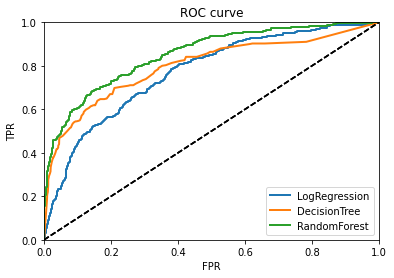

In [68]:
plot_roc_curve(fpr_logr_best,tpr_logr_best,'LogRegression')
plot_roc_curve(fpr_dtcl_best,tpr_dtcl_best,'DecisionTree')
plot_roc_curve(fpr_rfcl_best,tpr_rfcl_best,'RandomForest')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

Видим, что обобщающая способность случайного леса, выраженная метрикой auc_roc выше, чем у других моделей.

## Борьба с дисбалансом

In [69]:
data['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Соотношение классов [1] и [0] в exited равно 1:4.

### Применим class_weight='balanced'

Применим class_weight='balanced' в исследуемых моделях. Найдем гиперпараметры для моделей.

#### Логистическая регрессия поиск ГП.

In [70]:
f1_best_list_logr_bal, roc_auc_best_list_logr_bal = logr_search(
                                              features_train,target_train,
                                              features_valid,target_valid,
                                              class_weight='balanced')

100%|██████████| 4/4 [00:20<00:00,  5.15s/it]


In [73]:
result_bal = pd.DataFrame(columns=[
    'f1','roc_auc','accuracy','recall','precission','C','max_iter'])

In [74]:
result_bal.loc['logr_f1']=f1_best_list_logr_bal
result_bal.loc['logr_roc_auc'] = roc_auc_best_list_logr_bal
result_bal

,f1,roc_auc,accuracy,recall,precission,C,max_iter
logr_f1,0.476360,0.772283,0.7065,0.682864,0.365753,0.1,100.0
logr_roc_auc,0.475936,0.772299,0.7060,0.682864,0.365253,1.0,100.0


F1 для лог регрессии с применением class_weight='balanced' увеличилось, но не достигло требуемого уровня

#### Дерево решений, поиск ГП.

In [75]:
f1_best_list_dtcl_bal, roc_auc_best_list_dtcl_bal = dtcl_search(
                                              features_train,target_train,
                                              features_valid,target_valid,
                                              class_weight='balanced')

100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


In [76]:
# посмотрим итоговые метрики
result_bal.loc['dtcl_f1',
           ['f1','roc_auc','accuracy','recall','precission',
      'max_depth','min_samples_split','min_samples_leaf']] = f1_best_list_dtcl_bal
result_bal.loc['dtcl_roc_auc',
           ['f1','roc_auc','accuracy','recall','precission',
'max_depth','min_samples_split','min_samples_leaf']]= roc_auc_best_list_dtcl_bal
result_bal.transpose()

,logr_f1,logr_roc_auc,dtcl_f1,dtcl_roc_auc
f1,0.476360,0.475936,0.511041,0.503650
roc_auc,0.772283,0.772299,0.750712,0.801296
accuracy,0.706500,0.706000,0.767500,0.728000
recall,0.682864,0.682864,0.621483,0.705882
precission,0.365753,0.365253,0.433929,0.391489
C,0.100000,1.000000,NaN,NaN
max_iter,100.000000,100.000000,NaN,NaN
max_depth,NaN,NaN,14.000000,10.000000
min_samples_split,NaN,NaN,2.000000,2.000000
min_samples_leaf,NaN,NaN,5.000000,17.000000


Значение F1 для дерева решений с применением class_weight='balanced' даже немного снизилось

#### Случайный лес, поиск ГП.

In [77]:
f1_best_list_rfcl_bal, roc_auc_best_list_rfcl_bal = rfcl_search(
                                              features_train,target_train,
                                              features_valid,target_valid,
                                              class_weight='balanced')

100%|██████████| 7/7 [08:50<00:00, 75.79s/it]


In [78]:
# посмотрим итоговые метрики
result_bal.loc['rfcl_f1',
           ['f1','roc_auc','accuracy','recall','precission',
            'max_depth','min_samples_split',
            'min_samples_leaf','n_estimators']] = f1_best_list_rfcl_bal
result_bal.loc['rfcl_roc_auc',
           ['f1','roc_auc','accuracy','recall','precission',
            'max_depth','min_samples_split',
            'min_samples_leaf','n_estimators']]= roc_auc_best_list_rfcl_bal
result_bal.transpose()

,logr_f1,logr_roc_auc,dtcl_f1,dtcl_roc_auc,rfcl_f1,rfcl_roc_auc
f1,0.476360,0.475936,0.511041,0.503650,0.615196,0.590542
roc_auc,0.772283,0.772299,0.750712,0.801296,0.851877,0.857086
accuracy,0.706500,0.706000,0.767500,0.728000,0.843000,0.822500
recall,0.682864,0.682864,0.621483,0.705882,0.641944,0.654731
precission,0.365753,0.365253,0.433929,0.391489,0.590588,0.537815
C,0.100000,1.000000,NaN,NaN,NaN,NaN
max_iter,100.000000,100.000000,NaN,NaN,NaN,NaN
max_depth,NaN,NaN,14.000000,10.000000,18.000000,10.000000
min_samples_split,NaN,NaN,2.000000,2.000000,14.000000,2.000000
min_samples_leaf,NaN,NaN,5.000000,17.000000,5.000000,9.000000


Видим, что при применении гиперпараметра балансировки выборки по целевому полю:
- логистическая регрессия значительно увеличила значение метрики f1 при сохранении roc_auc
- дерево решений незначительно снизило f1
- случайный лес показал лучшую обобщаюю способность на валидационной выборке. Метрика F1 выросла до 0.62, что является приемлемым значением по условиям задачи. Значение ROC_AUC осталось на том же уровне

Таким образом для тестирования на исходной выборке (без апсэмплирования) можем выбрать модель случайного леса с гиперпараметрами:


n_estimators=70, max_depth=17, min_samples_split=2,
min_samples_leaf=5, class_weight='balanced'

### Используем метод увеличения выборки (апсэмплирование)

Увеличим количество строк с классом [1] во всех выборках в 4 раза

In [79]:
from sklearn.utils import shuffle
# функция увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_ups, target_train_ups = upsample(features_train, target_train, 4)
#features_valid_ups, target_valid_ups = upsample(features_valid, target_valid, 4)
#features_test_ups, target_test_ups = upsample(features_test, target_test, 4)
display('Обучающая выборка признаков',features_train_ups.shape)
#display('Валидационная выборка  признаков',features_valid_ups.shape)
#display('Тестовая выборка  признаков',features_test_ups.shape)

'Обучающая выборка признаков'

(9657, 11)

Изначально сделал неправильный ход- увеличил также валидационную и тестовую выборку. Их ведь надо оставить нетронутыми

Обучим модели с найденными выше гиперпараметрами и посмотрим как изменятся метрики.

#### Логистическая регрессия, поиск ГП

In [80]:
f1_best_list_logr_ups, roc_auc_best_list_logr_ups = logr_search(
                                              features_train_ups,target_train_ups,
                                              features_valid,target_valid)

100%|██████████| 4/4 [00:17<00:00,  4.50s/it]


In [81]:
result_ups = pd.DataFrame(columns=[
    'f1','roc_auc','accuracy','recall','precission','C','max_iter'])

In [82]:
result_ups.loc['logr_f1']=f1_best_list_logr_ups
result_ups.loc['logr_roc_auc'] = roc_auc_best_list_logr_ups
result_ups

,f1,roc_auc,accuracy,recall,precission,C,max_iter
logr_f1,0.475856,0.772270,0.7015,0.693095,0.362299,0.1,100.0
logr_roc_auc,0.474100,0.772291,0.7005,0.690537,0.360963,1.0,100.0


Параметры те же. Метрика F1 лог.регресси заметно выросла. ROC_AUC не изменилась

#### Дерево решений, поиск ГП

In [83]:
f1_best_list_dtcl_ups, roc_auc_best_list_dtcl_ups = dtcl_search(
                                              features_train_ups,target_train_ups,
                                              features_valid,target_valid)

100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


In [84]:
# посмотрим итоговые метрики
result_ups.loc['dtcl_f1',
           ['f1','roc_auc','accuracy','recall','precission',
      'max_depth','min_samples_split','min_samples_leaf']] = f1_best_list_dtcl_ups
result_ups.loc['dtcl_roc_auc',
           ['f1','roc_auc','accuracy','recall','precission',
'max_depth','min_samples_split','min_samples_leaf']]= roc_auc_best_list_dtcl_ups
result_ups.transpose()

,logr_f1,logr_roc_auc,dtcl_f1,dtcl_roc_auc
f1,0.475856,0.474100,0.516685,0.497332
roc_auc,0.772270,0.772291,0.760930,0.780001
accuracy,0.701500,0.700500,0.775500,0.764500
recall,0.693095,0.690537,0.613811,0.595908
precission,0.362299,0.360963,0.446097,0.426740
C,0.100000,1.000000,NaN,NaN
max_iter,100.000000,100.000000,NaN,NaN
max_depth,NaN,NaN,14.000000,18.000000
min_samples_split,NaN,NaN,22.000000,2.000000
min_samples_leaf,NaN,NaN,9.000000,17.000000


Метрика F1 для решающего дерева даже снизилась. ROC_AUC также немного снизилась.

#### Случайный лес. Поиск ГП.

In [85]:
f1_best_list_rfcl_ups, roc_auc_best_list_rfcl_ups = rfcl_search(
                                              features_train_ups,target_train_ups,
                                              features_valid,target_valid)

100%|██████████| 7/7 [12:26<00:00, 106.58s/it]


In [86]:
# посмотрим итоговые метрики
result_ups.loc['rfcl_f1',
           ['f1','roc_auc','accuracy','recall','precission',
            'max_depth','min_samples_split',
            'min_samples_leaf','n_estimators']] = f1_best_list_rfcl_ups
result_ups.loc['rfcl_roc_auc',
           ['f1','roc_auc','accuracy','recall','precission',
            'max_depth','min_samples_split',
            'min_samples_leaf','n_estimators']]= roc_auc_best_list_rfcl_ups
result_ups.transpose()

,logr_f1,logr_roc_auc,dtcl_f1,dtcl_roc_auc,rfcl_f1,rfcl_roc_auc
f1,0.475856,0.474100,0.516685,0.497332,0.604982,0.592920
roc_auc,0.772270,0.772291,0.760930,0.780001,0.849652,0.856151
accuracy,0.701500,0.700500,0.775500,0.764500,0.833500,0.816000
recall,0.693095,0.690537,0.613811,0.595908,0.652174,0.685422
precission,0.362299,0.360963,0.446097,0.426740,0.564159,0.522417
C,0.100000,1.000000,NaN,NaN,NaN,NaN
max_iter,100.000000,100.000000,NaN,NaN,NaN,NaN
max_depth,NaN,NaN,14.000000,18.000000,18.000000,10.000000
min_samples_split,NaN,NaN,22.000000,2.000000,2.000000,22.000000
min_samples_leaf,NaN,NaN,9.000000,17.000000,5.000000,5.000000


Видим, что значение метрики F1 на апсемплированных выборках заметно выросли у лог. регресси и у случайного леса. Дерево решений снизило значение метрики

Максимальная метрика F1 и  ROC_AUC по прежнему у случайного леса.

Таким образом на тестовых данных буду использовать модель случайного леса в двух вариантах:
- на неувеличенной выборке с гиперпараметрами:  n_estimators=70, max_depth=17, min_samples_split=2, min_samples_leaf=5, class_weight='balanced'
- на увеличенной выборке с ГП: n_estimators=70, max_depth=18,                        min_samples_leaf=5, min_samples_split=2

## Тестирование модели

Не увеличенная выборка

In [87]:
# Инициализируем модель 
rfcl_best_bal = RandomForestClassifier(random_state=12345, n_estimators=70,
                                       max_depth=17,min_samples_leaf=5,
                                       min_samples_split=2,class_weight='balanced')

In [88]:
rfcl_best_fited_bal = best_model(rfcl_best_bal,features_train_ups,target_train_ups,
                             features_test,target_test,prnt=True)

метрика f1 ---------- 0.64309
метрика roc_auc ----- 0.8638
метрика accuracy ---- 0.8385
метрика recall ------ 0.6815
метрика precission -- 0.6088


На тестовой выборке получили требуемое значение F1 > 0.59

Увеличенная выборка

In [89]:
# Случайный лес
rfcl_best_ups = RandomForestClassifier(random_state=12345,
                                           n_estimators=70, max_depth=18,
                                           min_samples_leaf=2,
                                           min_samples_split=5)

rfcl_best_fited_ups = best_model(rfcl_best_ups,features_train_ups,target_train_ups,
                             features_test,target_test,prnt=True)

метрика f1 ---------- 0.6247
метрика roc_auc ----- 0.8566
метрика accuracy ---- 0.845
метрика recall ------ 0.6042
метрика precission -- 0.6466


Значние F1 на увеличенной выборке немного меньше, чем с использованием class_weight='balanced'

В обоих вариантах балансирования значение F1 на тесте выросло по сравнению с валидацией

Общий вывод касательно балансировки классов могу сделать следующий: с точки зрения увеличения метрики F1 методы апсэмплирования и применения гиперпараметра class_weight='balanced' одинаково эффективны. При этом метрика roc_auc после балансировки изменяется незначительно.

Полученная модель очевидно правильно обнаруживает только 64% из всех фактически ушедших клиентов (доля ложно отрицательных предсказаний, соответственно = 36%)

In [90]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train_ups, target_train_ups)
f1_const = f1_score(dummy_model.predict(features_test), target_test)
print('F1 для константной модели:',f1_const)

F1 для константной модели: 0.3518747424804285


Проверку модели на адекватность прошли. F1 для константной модели значительно ниже полученного моделью.